## To do

1. Process data to be in format of (batch_size, frames_length, frame_size*frame_size)
2. Build RNN model
    * RNN cell: 1 layer, identity matrix initialization, relu activation
    * FC linear layer
    * Start with building single-shot model, then work up to autoregressive model
      * Single-shot    = 7 inputs, 1 output
      * Autoregressive = warmup... 1 input, 1 output repeatedly fed into model
3. Train model
4. Visualise weights
    * Input weights
    * Spike triggered averaging
    
    
## Autoregressive model
    t_steps = 8
    warmup_data = [] # (sequence_length=40, features=20*20)
    h_0 = [] # identity matrix
    preds = []
    
    h_s = h_0
    for frame in warmup_data:
        h_s = rnn_cell(frame, h_s)
    pred = dense(h_s)
    preds.append(dense)

    for n in range(t_steps):
        h_s = rnn_cell(pred, h_s)
        pred = dense(out)
        preds.append(pred)
    
    loss = loss(preds, ys) 

In [ ]:
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline

T_STEPS = 7
FRAME_SIZE = 20

In [ ]:
class FramesDataset (torch.utils.data.Dataset):
    def __init__ (self, path, split_type):
        with open(path, 'rb') as file:
            dataset = pickle.load(file)

        n = len(dataset)
        splits = {
            "train": slice(0, int(n*0.8)),
            "val": slice(int(n*0.8), int(n*0.9)),
            "test": slice(int(n*0.9), None)
        }

        dataset = dataset[splits[split_type]]
        reordered = []
        for example in dataset:
            frames = []
            for i in range(example.shape[-1]):
                frame = example[:, :, i]
                frames.append(frame.flatten())
            reordered.append(frames)
                             
        self.dataset = torch.from_numpy(np.array(reordered))
        self.dataset = self.dataset.type(torch.FloatTensor)
    def __len__ (self):
        return len(self.dataset)
    def __getitem__ (self, i):
        window = self.dataset[i] # (size, size, time_steps)
        x = window[:-1, :]
        y = window[-1, :]

        return x, y

train_dataset = FramesDataset('./processed_dataset.pkl', 'train')
val_dataset = FramesDataset('./processed_dataset.pkl', 'val')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

In [170]:
class RNN_Network (nn.Module):
    def __init__ (self):
        super(RNN_Network, self).__init__()
        hidden_units = 2000
        
        self.rnn = nn.RNN(
            input_size=FRAME_SIZE**2,
            hidden_size=hidden_units,
            num_layers=1,
            nonlinearity='relu',
            batch_first=True
        )
        self.rnn.weight_hh_l = torch.nn.Parameter(torch.eye(hidden_units, hidden_units))

        
        self.fc = nn.Linear(hidden_units, FRAME_SIZE*FRAME_SIZE)
    def forward (self, x):
        out, hidden = self.rnn(x)
        out = self.fc(out[:, -1, :])
        
        return out
    
def L1_regularisation (lam, loss, model):
    weights = torch.Tensor([])
    for name, params in model.named_parameters():
        if name.endswith('weight'):
            weights = torch.cat((weights, params.flatten()), 0)
    
    return loss + lam*weights.abs().sum()

In [171]:
net = RNN_Network()

n_epochs = 100
lr=0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(1, n_epochs + 1):
    for batch_n, data in enumerate(train_data_loader):
        inputs, targets = data
    
        optimizer.zero_grad()
        output = net(inputs)
        loss = L1_regularisation(10e-6, criterion(output, targets), net)
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)  #Gradient Value Clipping
        optimizer.step()

    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Loss: {:.4f}".format(loss.item()))

Epoch: 1/100............. Loss: 0.6196
Epoch: 2/100............. Loss: 0.5299
Epoch: 3/100............. Loss: 0.4722
Epoch: 4/100............. Loss: 0.4320
Epoch: 5/100............. Loss: 0.4061
Epoch: 6/100............. Loss: 0.3828
Epoch: 7/100............. Loss: 0.3583
Epoch: 8/100............. Loss: 0.3428
Epoch: 9/100............. Loss: 0.3367
Epoch: 10/100............. Loss: 0.3260
Epoch: 11/100............. Loss: 0.3185
Epoch: 12/100............. Loss: 0.3099
Epoch: 13/100............. Loss: 0.2966
Epoch: 14/100............. Loss: 0.2913
Epoch: 15/100............. Loss: 0.2780
Epoch: 16/100............. Loss: 0.2817
Epoch: 17/100............. Loss: 0.2838
Epoch: 18/100............. Loss: 0.2860
Epoch: 19/100............. Loss: 0.2757
Epoch: 20/100............. Loss: 0.2629
Epoch: 21/100............. Loss: 0.2734
Epoch: 22/100............. Loss: 0.2892
Epoch: 23/100............. Loss: 0.3048
Epoch: 24/100............. Loss: 0.2703
Epoch: 25/100............. Loss: 0.2578
Epoch: 26

KeyboardInterrupt: 

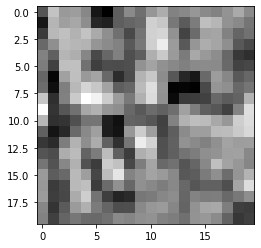

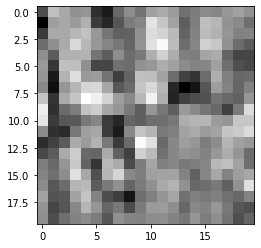

In [174]:
x, y = train_dataset[560]

pred = net(torch.unsqueeze(x, 0))

im_pred = pred.view(20, 20).detach().numpy()
im_y = y.view(20, 20).detach().numpy()

plt.imshow(im_pred, cmap='gray')
plt.show()
plt.imshow(im_y, cmap='gray')